In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Loading Data
df = pd.read_csv('Twotonguetwisters.txt', sep="\n", header=None)
df.columns = ["Description"]
df.head()

#Adding the Categories to the dataframe
categories = ['C1', 'C1', 'C1', 'C2', 'C2']
df['Category'] = categories
df.head()

,Description,Category
0,Peter Piper picked a peck of pickled peppers.,C1
1,A peck of pickled peppers Peter Piper picked.,C1
2,Where is the peck of pickled peppers Peter Pip...,C1
3,How much wood would a woodchuck chuck if a woo...,C2
4,As a woodchuck would if a woodchuck could chuc...,C2


In [3]:
print(f'There are {len(df)} records')

There are 5 records


In [4]:
#Checking for missing values, ensuring data is complete.
df.isnull().sum()

Description    0
Category       0
dtype: int64

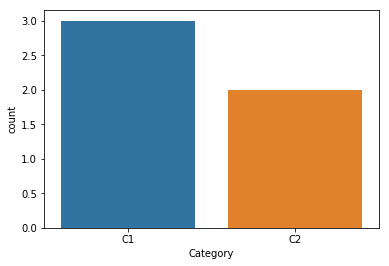

In [5]:
#Visualizing the split between the data categories
sns.countplot(df.Category)

In [6]:
df['Category'].value_counts()

C1    3
C2    2
Name: Category, dtype: int64

#We see that out of 5, 3 of them are classified as C1.
#Our model must perform better than 67% to beat random chance.

In [7]:
#Splitting the data into train & test sets:
from sklearn.model_selection import train_test_split

x = df['Description']
y = df['Category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

y_train = np.where(y_train=='C1',1,0)
y_test = np.where(y_test=='C1',1,0)

In [8]:
#Creating a bag of words with word counts using SckKit Learn's CountVectorizer

#Defining a tokenizer for use by scikit-learn
import re
re_tok = re.compile('[^a-zA-z]')
def tokenize(s):
    return re_tok.sub(' ', s).split()

In [9]:
#Using SciKit Learn's CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#Tokenizing and removing stop words using CountVectorizer's Built-In English List
count_vect = CountVectorizer(tokenizer = tokenize, stop_words='english')
print(count_vect)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x1a19332e18>, vocabulary=None)


In [10]:
tf_train = count_vect.fit_transform(x_train)
tf_test = count_vect.transform(x_test)

In [11]:
print(f'Train term frequency contains {tf_train.shape[0]} documents and {tf_train.shape[1]} tokens.\nEach row represents a document and each column how many times a token appears on the document')

Train term frequency contains 3 documents and 9 tokens.
Each row represents a document and each column how many times a token appears on the document


In [12]:
tf_train

<3x9 sparse matrix of type '<class 'numpy.int64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [13]:
tf_train[0]

<1x9 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [14]:
tf_test

<2x9 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [15]:
#Getting vocabulary
vocab = count_vect.get_feature_names()
len(vocab)

9

In [16]:
vocab

['chuck',
 'peck',
 'peppers',
 'peter',
 'picked',
 'pickled',
 'piper',
 'wood',
 'woodchuck']

In [17]:
# Displaying the Categories of the training data
y_train

array([1, 1, 0])

In [18]:
#Generating and saving bags of words for training data
pd.DataFrame(tf_train.toarray(), columns=vocab).to_csv(r'Train-bagOfWords.csv')
pd.DataFrame(tf_train.toarray(), columns=vocab).to_csv

<bound method NDFrame.to_csv of    chuck  peck  peppers  peter  picked  pickled  piper  wood  woodchuck
0      0     1        1      1       1        1      1     0          0
1      0     1        1      1       1        1      1     0          0
2      2     0        0      0       0        0      0     2          2>

In [19]:
#Displaying the Categories of the test data
y_test

array([1, 0])

In [20]:
#Generating and saving bag of words for test data
pd.DataFrame(tf_test.toarray(), columns=vocab).to_csv(r'Test-bagOfWords.csv')
pd.DataFrame(tf_test.toarray(), columns=vocab).to_csv

<bound method NDFrame.to_csv of    chuck  peck  peppers  peter  picked  pickled  piper  wood  woodchuck
0      0     1        1      1       1        1      1     0          0
1      1     0        0      0       0        0      0     1          2>

In [21]:
#Training and testing a multinomial NB model using Scikit-learn and word counts
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(tf_train, y_train)

In [22]:
# get probabilities for positive class
probs = model.predict_proba(tf_test)[:,1]

In [23]:
# get predictions
predictions = model.predict(tf_test)

In [24]:
#Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score 
from sklearn.metrics import confusion_matrix,roc_curve, auc

In [25]:
# Report the predctive performance metrics
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
precision=precision_score(y_test, predictions, )
recall=recall_score(y_test, predictions)
specificity=recall_score(y_test, predictions, pos_label=0)
roc = roc_auc_score(y_test, probs)

print("\n")
print(f"Accuracy.........: {accuracy * 100.0:.4f}")
print(f"Precision........: {precision *100:.4f}")
print(f"Recall...........: {recall * 100:.4f}")
print(f"FP Rate...........:{(1-specificity) * 100:.4f}")
print(f"ROC AUC (probs)..: {roc:.6f}")

cm = confusion_matrix(y_test, predictions)
print(f"Confusion matrix.:\n {cm}")



Accuracy.........: 100.0000
Precision........: 100.0000
Recall...........: 100.0000
FP Rate...........:0.0000
ROC AUC (probs)..: 1.000000
Confusion matrix.:
 [[1 0]
 [0 1]]


In [29]:
#Predicting whether the following document belongs to category C1 or C2
#"The woodchuck picked peppers and chucked wood."
print(model.predict(count_vect.transform(["The woodchuck picked peppers and chucked wood."])))

[0]


In [30]:
#According to the result, the document would be classified as a C2 Category.